In [1]:
# -*- coding: utf-8 -*-
# ESTUDIO HONESTIDAD (mayo–septiembre) — robusto con CSV “raros”
# Requiere: pandas, matplotlib, python-docx
# pip install pandas matplotlib python-docx

import re, os, io
import pandas as pd
import matplotlib.pyplot as plt
from docx import Document
from docx.shared import Pt, Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH

# ========= CONFIG =========
FAMILIA_OBJETIVO = "HONESTIDAD"   # cambia aquí si quieres otra familia
archivos = ["mayo.csv","junio.csv","julio.csv","agosto.csv","septiembre.csv"]
salida_docx = "Informe_HONESTIDAD.docx"
salida_png  = "HONESTIDAD_evolucion.png"
# =========================

def es_cabecera_seccion(linea:str)->bool:
    # línea que parece título de familia (mayúsculas, sin columnas númericas)
    t = linea.strip().replace("Í","I").replace("Á","A").replace("É","E").replace("Ó","O").replace("Ú","U").replace("Ñ","N")
    if not t: return False
    # suele venir sin comillas ni separadores
    return (t.upper()==t) and (len(t.split())<=4) and (not any(ch.isdigit() for ch in t))

def parse_num(x):
    """Convierte '1.234,56' -> 1234.56 y maneja vacíos/0."""
    if x is None: return 0.0
    s = str(x).strip().replace('"','').replace("'",'')
    if s=="" or s.lower()=="nan": return 0.0
    # aceptar guiones negativos tipo -167,52
    s = s.replace('.', '').replace(' ', '')
    s = s.replace(',', '.')
    try:
        return float(s)
    except:
        # a veces viene 0,00% u otras cosas
        s = re.sub(r'[^0-9\.\-]','', s)
        return float(s) if s not in ("", ".", "-") else 0.0

def extraer_seccion_honestidad(path:str, familia=FAMILIA_OBJETIVO):
    """Devuelve DataFrame con columnas: Código, Descripción, Unidades, Importe Total (solo familia objetivo)."""
    if not os.path.exists(path):
        return pd.DataFrame(columns=["Código","Descripción","Unidades","Importe Total"])

    # Leemos el fichero completo como texto (soporta exports raros)
    with io.open(path, 'r', encoding='latin-1', errors='ignore') as f:
        txt = f.read()

    lineas = [ln for ln in txt.splitlines() if ln.strip()!=""]

    # Encontrar la línea de la familia (case-insensitive)
    idx_ini = None
    for i, ln in enumerate(lineas):
        if es_cabecera_seccion(ln) and familia.lower() in ln.lower():
            idx_ini = i+1
            break
    if idx_ini is None:
        # No hay sección HONESTIDAD en este archivo
        return pd.DataFrame(columns=["Código","Descripción","Unidades","Importe Total"])

    # El bloque termina cuando aparece otra cabecera de familia
    idx_fin = len(lineas)
    for j in range(idx_ini, len(lineas)):
        if es_cabecera_seccion(lineas[j]) and familia.lower() not in lineas[j].lower():
            idx_fin = j
            break

    bloque = lineas[idx_ini:idx_fin]

    # Patrón de línea de producto:
    # Código  Descripción  "Unidades"  "Importe Total"  "Importe Total I.I." ...
    rgx = re.compile(
        r'^\s*([0-9A-Za-zçÇ]{1,10})\s+(.+?)\s+"?([-\d\.\,]+)"?\s+"?([-\d\.\,]+)"?',
        flags=re.UNICODE
    )

    rows = []
    for ln in bloque:
        m = rgx.match(ln)
        if not m:
            continue
        codigo = m.group(1).strip()
        desc   = m.group(2).strip()
        unidades = parse_num(m.group(3))
        importe  = parse_num(m.group(4))   # “Importe Total” (pre I.I.) según export
        # Filtramos líneas evidentemente no-producto (p.ej. totales o códigos vacíos)
        if codigo.lower() in ("total","totales"): 
            continue
        rows.append([codigo, desc, unidades, importe])

    df = pd.DataFrame(rows, columns=["Código","Descripción","Unidades","Importe Total"])
    # Quitar los “cero precio” si son artículos “honestidad gratis” -> los dejamos (forman parte del consumo).
    return df

# ====== PROCESO POR MES ======
resumen = []
by_month_tables = {}   # para insertar en el Word

for path in archivos:
    df = extraer_seccion_honestidad(path)
    mes = os.path.basename(path)
    if df.empty:
        resumen.append([mes, 0, 0.0, 0.0])
        by_month_tables[mes] = df
        continue

    # Orden por Importe Total descendente para lectura más fácil
    df = df.sort_values(["Importe Total","Unidades"], ascending=[False, False]).reset_index(drop=True)

    total_unid = int(df["Unidades"].sum())
    total_imp  = float(df["Importe Total"].sum())
    eur_unit   = (total_imp / total_unid) if total_unid>0 else 0.0

    resumen.append([mes, total_unid, round(total_imp,2), round(eur_unit,3)])
    by_month_tables[mes] = df

df_resumen = pd.DataFrame(resumen, columns=["Mes","Unidades","Importe (€)","€/unidad"]).replace({pd.NA:0})

# ====== GRÁFICO EVOLUCIÓN ======
meses_orden = [os.path.splitext(os.path.basename(a))[0].capitalize() for a in archivos]
u = [int(x) for x in df_resumen["Unidades"]]
imp = [float(x) for x in df_resumen["Importe (€)"]]

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(meses_orden, u, alpha=0.7, label="Unidades (HONESTIDAD)")
ax1.set_ylabel("Unidades", color="tab:blue")
for i, val in enumerate(u):
    ax1.text(i, val*1.01, f"{val:,}".replace(",","."), ha='center', va='bottom', fontsize=9, color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(meses_orden, imp, 'o-', linewidth=2, label="Importe total (€)", color="tab:red")
ax2.set_ylabel("Importe total (€)", color="tab:red")
for i, val in enumerate(imp):
    ax2.text(i, val*1.01, f"{val:,.2f}€".replace(",","."), ha='center', va='bottom', fontsize=9, color='tab:red')

plt.title("Evolución Mensual — HONESTIDAD (Unidades e Importe)", fontsize=14, fontweight="bold")
fig.tight_layout()
plt.savefig(salida_png, dpi=160)
plt.close(fig)

# ====== INFORME WORD ======
doc = Document()

# Título
titulo = doc.add_heading("Informe mensual — HONESTIDAD (Consumos y facturación)", level=1)
titulo.alignment = WD_ALIGN_PARAGRAPH.CENTER

p = doc.add_paragraph(
    "Resumen detallado de consumos de la familia HONESTIDAD por mes. "
    "Incluye totales de unidades e importes, €/unidad y tablas por producto. "
    "Fuente: ficheros mensuales (mayo–septiembre)."
)
p.paragraph_format.space_after = Pt(6)

# Gráfico
doc.add_picture(salida_png, width=Inches(6.5))
cap = doc.add_paragraph("Figura 1. Evolución mensual de Unidades (barras) e Importe (€) (línea) — HONESTIDAD.")
cap.alignment = WD_ALIGN_PARAGRAPH.CENTER

# Resumen mensual (tabla)
doc.add_heading("Resumen mensual", level=2)
t = doc.add_table(rows=1, cols=len(df_resumen.columns))
hdr = t.rows[0].cells
for i, c in enumerate(df_resumen.columns):
    hdr[i].text = c
for _, row in df_resumen.iterrows():
    r = t.add_row().cells
    r[0].text = str(row["Mes"])
    r[1].text = f"{int(row['Unidades']):,}".replace(","," ")
    r[2].text = f"{float(row['Importe (€)']):,.2f}".replace(","," ").replace(".",",")
    r[3].text = f"{float(row['€/unidad']):.3f}".replace(".",",")

# Tablas por mes
doc.add_heading("Detalle por mes", level=2)
for path in archivos:
    mes = os.path.basename(path)
    df = by_month_tables[mes]
    doc.add_heading(mes.replace(".csv","").capitalize(), level=3)
    if df.empty:
        doc.add_paragraph("No hay registros de HONESTIDAD en este archivo.")
        continue
    # Totales
    tu = int(df["Unidades"].sum()); ti = float(df["Importe Total"].sum())
    doc.add_paragraph(f"Unidades: {tu:,}".replace(","," "))
    doc.add_paragraph(f"Importe total (€): {ti:,.2f}".replace(","," ").replace(".",","))

    # Tabla productos
    cols = ["Código","Descripción","Unidades","Importe Total"]
    tb = doc.add_table(rows=1, cols=len(cols))
    for i,c in enumerate(cols):
        tb.rows[0].cells[i].text = c
    for _, r in df[cols].iterrows():
        tr = tb.add_row().cells
        tr[0].text = str(r["Código"])
        tr[1].text = str(r["Descripción"])
        tr[2].text = f"{int(r['Unidades']):,}".replace(","," ")
        tr[3].text = f"{float(r['Importe Total']):,.2f}".replace(","," ").replace(".",",")

# Conclusiones automáticas (breves)
doc.add_heading("Observaciones y recomendaciones", level=2)
txt = []
if df_resumen["Unidades"].sum()==0:
    txt.append("No se registran consumos en HONESTIDAD en los meses analizados.")
else:
    # mes con mayor importe
    imax = df_resumen.iloc[df_resumen["Importe (€)"].idxmax()]
    imin = df_resumen.iloc[df_resumen["Importe (€)"].idxmin()]
    txt.append(f"• Mes con mayor importe: {imax['Mes']} ({imax['Importe (€)']:.2f} €).")
    txt.append(f"• Mes con menor importe: {imin['Mes']} ({imin['Importe (€)']:.2f} €).")
    # €/unidad alto/bajo (proxy de ticket/valor)
    cu_max = df_resumen.iloc[df_resumen["€/unidad"].idxmax()]
    cu_min = df_resumen.iloc[df_resumen["€/unidad"].idxmin()]
    txt.append(f"• Mayor €/unidad: {cu_max['Mes']} ({cu_max['€/unidad']:.3f} €/ud).")
    txt.append(f"• Menor €/unidad: {cu_min['Mes']} ({cu_min['€/unidad']:.3f} €/ud).")
    # tendencia simple (primer vs último)
    if len(df_resumen)>=2:
        p0, p1 = df_resumen.iloc[0], df_resumen.iloc[-1]
        t_imp = (p1["Importe (€)"]-p0["Importe (€)"])/p0["Importe (€)"]*100 if p0["Importe (€)"] else 0
        t_un  = (p1["Unidades"]-p0["Unidades"])/p0["Unidades"]*100 if p0["Unidades"] else 0
        txt.append(f"• Tendencia {df_resumen.iloc[0]['Mes']}→{df_resumen.iloc[-1]['Mes']}: "
                   f"Unidades {t_un:+.1f}% | Importe {t_imp:+.1f}%.")

doc.add_paragraph("\n".join(txt))
doc.save(salida_docx)

print("✅ Listo.")
print(df_resumen)
print(f"\nSe han creado:\n- {salida_png}\n- {salida_docx}")


✅ Listo.
              Mes  Unidades  Importe (€)  €/unidad
0        mayo.csv       140       277.63     1.983
1       junio.csv       150       311.08     2.074
2       julio.csv       132       267.50     2.027
3      agosto.csv       110       215.81     1.962
4  septiembre.csv       117       256.96     2.196

Se han creado:
- HONESTIDAD_evolucion.png
- Informe_HONESTIDAD.docx


C:\Users\sgcov\AppData\Local\Temp\ipykernel_22724\1839999899.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\sgcov\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


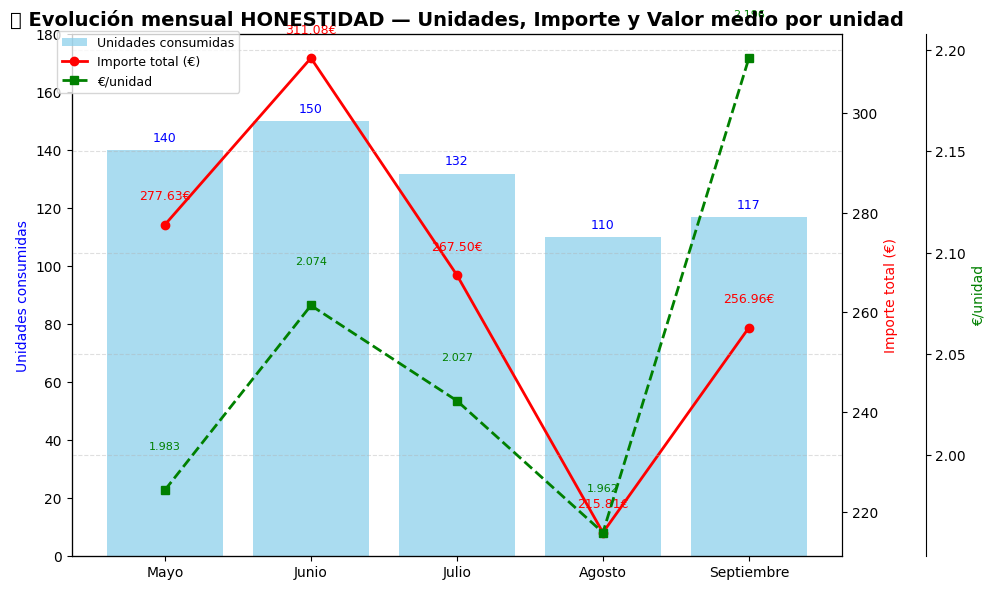

In [2]:
import matplotlib.pyplot as plt

# Datos obtenidos del resumen HONESTIDAD
meses = ["Mayo", "Junio", "Julio", "Agosto", "Septiembre"]
unidades = [140, 150, 132, 110, 117]
importe = [277.63, 311.08, 267.50, 215.81, 256.96]
precio_medio = [1.983, 2.074, 2.027, 1.962, 2.196]

# --- Gráfico combinado ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barras azules: unidades
barras = ax1.bar(meses, unidades, color='skyblue', alpha=0.7, label='Unidades consumidas')
ax1.set_ylabel('Unidades consumidas', color='blue')
ax1.set_ylim(0, max(unidades) * 1.2)
for i, v in enumerate(unidades):
    ax1.text(i, v + 3, str(v), ha='center', color='blue', fontsize=9)

# Línea roja: importe total
ax2 = ax1.twinx()
ax2.plot(meses, importe, 'o-', color='red', linewidth=2, label='Importe total (€)')
ax2.set_ylabel('Importe total (€)', color='red')
for i, v in enumerate(importe):
    ax2.text(i, v + 5, f"{v:.2f}€", ha='center', color='red', fontsize=9)

# Línea verde: €/unidad (tercer eje)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # tercer eje desplazado a la derecha
ax3.plot(meses, precio_medio, 's--', color='green', linewidth=2, label='€/unidad')
ax3.set_ylabel('€/unidad', color='green')
for i, v in enumerate(precio_medio):
    ax3.text(i, v + 0.02, f"{v:.3f}", ha='center', color='green', fontsize=8)

# Título y formato general
plt.title("📊 Evolución mensual HONESTIDAD — Unidades, Importe y Valor medio por unidad", fontsize=14, fontweight='bold')
fig.tight_layout()

# Leyenda combinada
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2, ax3]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper left", bbox_to_anchor=(0.05, 0.95), fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


=== RESUMEN DE HONESTIDAD ===
          MES  TOTAL_REPUESTO  COBRADAS_TPV  HONESTIDAD_%  PÉRDIDA_ESTIMADA_€
0        MAYO             124           140    112.903226          -31.729143
1       JUNIO             127           150    118.110236          -47.698933
2       JULIO             145           132     91.034483           26.344697
3      AGOSTO             133           110     82.706767           45.123909
4  SEPTIEMBRE             127           117     92.125984           21.962393


C:\Users\sgcov\AppData\Local\Temp\ipykernel_22724\2005807373.py:55: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\sgcov\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


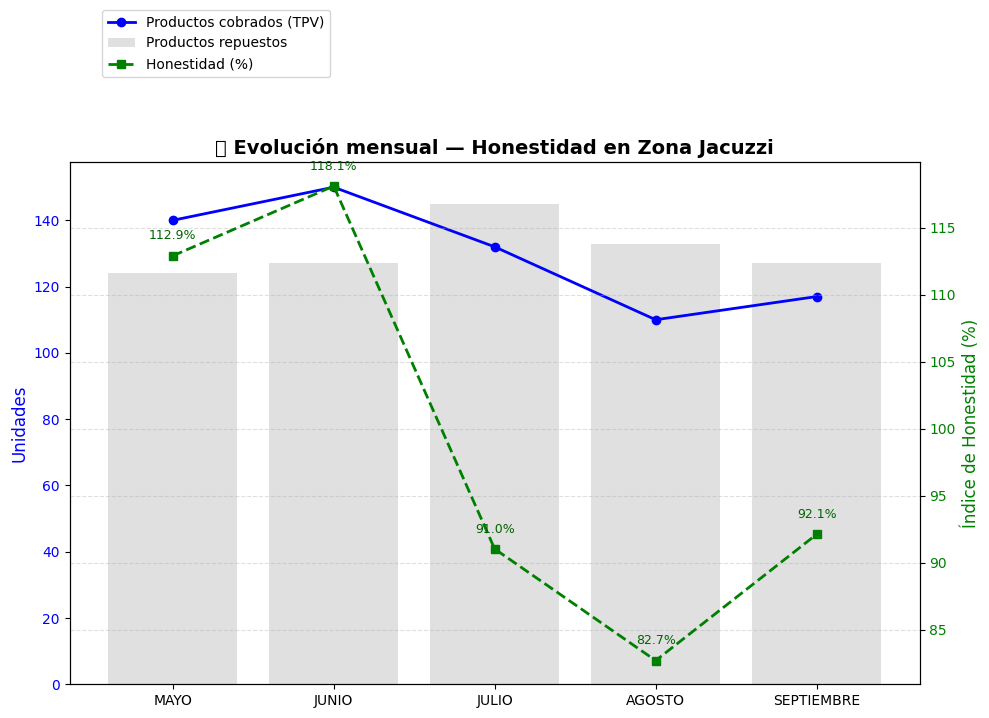

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1️⃣ Cargar datos de reposición ---
repos = pd.read_excel("reposicion.xlsx")

# --- 2️⃣ Calcular total repuesto ---
repos["TOTAL_REPUESTO"] = (
    repos["COMBINADOS HONEST."] + 
    repos["CERVEZA HONEST."] + 
    repos["HONEST. REFRES./ ZUMOS /AGUA"]
)

# --- 3️⃣ Datos reales cobrados del TPV (tu resumen previo) ---
tpv = pd.DataFrame({
    "MES": ["MAYO", "JUNIO", "JULIO", "AGOSTO", "SEPTIEMBRE"],
    "COBRADAS_TPV": [140, 150, 132, 110, 117],
    "IMPORTE (€)": [277.63, 311.08, 267.50, 215.81, 256.96]
})

# --- 4️⃣ Unir ambos DataFrames por mes ---
df = pd.merge(repos, tpv, on="MES")

# --- 5️⃣ Calcular índice de honestidad ---
df["HONESTIDAD_%"] = (df["COBRADAS_TPV"] / df["TOTAL_REPUESTO"]) * 100

# --- 6️⃣ Calcular pérdida estimada (€) ---
# Suponiendo que cada unidad equivale al precio medio mensual (importe/unidades)
df["€/unidad"] = df["IMPORTE (€)"] / df["COBRADAS_TPV"]
df["PÉRDIDA_ESTIMADA_€"] = (df["TOTAL_REPUESTO"] - df["COBRADAS_TPV"]) * df["€/unidad"]

print("=== RESUMEN DE HONESTIDAD ===")
print(df[["MES", "TOTAL_REPUESTO", "COBRADAS_TPV", "HONESTIDAD_%", "PÉRDIDA_ESTIMADA_€"]])

# --- 7️⃣ Gráfico combinado ---
fig, ax1 = plt.subplots(figsize=(10,6))

# Barras: total repuesto
ax1.bar(df["MES"], df["TOTAL_REPUESTO"], color='lightgray', alpha=0.7, label='Productos repuestos')
ax1.plot(df["MES"], df["COBRADAS_TPV"], 'o-b', linewidth=2, label='Productos cobrados (TPV)')
ax1.set_ylabel("Unidades", color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Línea verde: % de honestidad
ax2 = ax1.twinx()
ax2.plot(df["MES"], df["HONESTIDAD_%"], 's--g', linewidth=2, label='Honestidad (%)')
ax2.set_ylabel("Índice de Honestidad (%)", color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Etiquetas
for i, v in enumerate(df["HONESTIDAD_%"]):
    ax2.text(i, v + 1, f"{v:.1f}%", ha='center', va='bottom', fontsize=9, color='darkgreen')

plt.title("💧 Evolución mensual — Honestidad en Zona Jacuzzi", fontsize=14, fontweight='bold')
fig.tight_layout()

# Leyenda combinada
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper left", bbox_to_anchor=(0.1, 1.2))

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()
